<a id=contents></a>

# Exploratory Data Analysis
## Our clean data at a glance


[1. Data Inspection](#insp)

[2. TF-IDF : Term Frequency Inverse Doc Frequency](#corr)

[3. How does this affect it? (playing with some barplots and hue](#bar)

[4. Mentions of Elon and how sentiment varies](#one)

[5. EDA 2](#two)

[6. EDA 3](#three)

[7. Conclusions and ideas going forward](#conc)

In [2]:
%load_ext autoreload
%autoreload 2
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as shc

import matplotlib.pyplot as plt
import seaborn as sns
import plotly_express as px
%matplotlib inline
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
# import stri

import warnings
warnings.filterwarnings('ignore')

import os
import gensim
import numpy as np 
import functions.functions as fn
import pandas as pd

import spacy
from spacymoji import Emoji


2022-10-11 12:51:39.819170: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:

import gensim.downloader as api
from spacy_download import load_spacy
from gensim import corpora, models, similarities
from gensim.models.word2vec import Word2Vec


<a id=insp ><a/> 

## 1. Data Inspection
    
[LINK to table of contents](#contents)

In [3]:
# vect = pd.read_csv('data/clean/features/count_vect_feats.csv', index_col=0)
df = pd.read_csv('data/clean/clean_display_data.csv', index_col=0)

In [49]:
df.head(1)

,tweet_id,datetime,display_name,tweet_text,User_id,extracted_twitter_handles,extracted_URLs,extracted_hashtags,clean_tweet_text
0,1.579300e+18,2022-10-10 02:36:00+00:00,ElonMusk,@CathieDWood 💯,44196397.0,['@CathieDWood'],[],[],💯


<a id=corr ><a/> 

## 2.  Getting TF-IDF scores by user
    
[LINK to table of contents](#contents)

<a id=bar><a/> 

## 3. Turning to Doc Vectors in Gensim
   
[LINK to table of contents](#contents)

Inspiration for this part was taken partialy from [this blog post on visualising Twitter data](#https://towardsdatascience.com/visualizing-tweet-vectors-using-python-e528358bce68).

In [2]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [4]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)


In [4]:
### take data from clean
### tokenize

text_lst = pd.read_csv('data/clean/clean_display_data.csv')[['tweet_id', 'clean_tweet_text']].dropna(subset=['clean_tweet_text']) #.to_list()


In [7]:
# nlp = load_spacy("en_core_web_sm", exclude=["parser", "tagger"])
corpus = api.load('text8')


In [9]:
model = Word2Vec(corpus)

In [ ]:
# text_lst['tokens'] = text_lst['clean_tweet_text'].apply(lambda x : fn.tokenizer.tokenize(x) if x==x else np.NAN) 

# text_df = text_lst.dropna(subset=['tokens'])

In [10]:
# text_df.to_csv('data/clean/features/clean_text_and_tokens.csv')
text_df = pd.read_csv('data/clean/features/clean_text_and_tokens.csv')

In [11]:
sample_df = text_df.sample(n=10000, random_state=12345)
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 59955 to 273635
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        10000 non-null  int64  
 1   tweet_id          10000 non-null  float64
 2   clean_tweet_text  10000 non-null  object 
 3   tokens            10000 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 390.6+ KB


In [14]:
# Takes nearly 8 mins to run

tweet_vectors = sample_df['tokens'].apply(lambda x : fn.get_tweet_as_embed(x, model))

In [15]:
sample_df['wv'] = tweet_vectors
sample_df.dropna(subset=['wv'], inplace=True)
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9432 entries, 59955 to 273635
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        9432 non-null   int64  
 1   tweet_id          9432 non-null   float64
 2   clean_tweet_text  9432 non-null   object 
 3   tokens            9432 non-null   object 
 4   wv                9432 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 442.1+ KB


In [28]:
print('Fitting PCA transform...')  
from sklearn.decomposition import PCA
pca = PCA(n_components=2)  
# pca.fit([x.reshape(100,1) for x in sample_df.wv.to_list()])


Fitting PCA transform...


In [33]:
sample_df.wv.to_list()[0]

array([ 0.38559496, -0.9775177 , -0.39414936, -0.1721001 ,  0.03857432,
        1.0376482 ,  0.7962078 ,  0.26480404, -0.31981573,  0.9934202 ,
        0.22423853, -0.5533085 , -1.3706098 , -1.8103887 , -0.7405857 ,
        0.12695286,  0.71789604, -1.9810565 ,  0.04373063, -0.9830181 ,
       -0.44745192,  0.6412425 ,  0.55204755,  0.11231718, -0.37773204,
        0.4291375 , -0.31242186, -0.53230596, -0.8828055 ,  0.7324333 ,
       -0.78958267, -1.2788556 , -0.4888073 , -0.4726178 , -1.5964853 ,
       -0.20289418, -1.1670744 , -1.1394066 , -0.78510064, -0.04912381,
        1.0681186 ,  0.3050652 , -0.20289947,  1.0903221 ,  0.27361953,
       -0.10477936, -0.08466606, -0.7468922 ,  1.30472   , -0.822988  ,
        1.6658655 , -0.57859904,  0.20630872,  0.30368093, -0.27638108,
        1.4492102 , -1.1738073 ,  0.42754334,  1.0768877 ,  0.16373268,
        0.31682813,  0.40949723, -1.1404324 ,  1.0537012 , -1.8582664 ,
       -1.0307117 ,  0.21902668,  1.253467  ,  0.24133699, -0.50

In [38]:
pca.fit(sample_df.wv.to_list())

PCA(n_components=2)

In [44]:

pca_sample = pd.DataFrame(pca.transform(sample_df.wv.to_list()), index = sample_df.index)
pca_sample = pca_sample.add_prefix('PC_',)
pca_df = sample_df.join(pca_sample)


In [47]:

pca_df = pca_df.merge(df[['tweet_id', 'datetime', 'display_name', 'Before_or_after_controversy']], how='left', on='tweet_id')
pca_df['ElonMusk'] = pca_df['display_name'].apply(lambda x : x=='ElonMusk')
pca_df['datetime'] = pd.to_datetime(pca_df['datetime'])


In [20]:
# takes over 17min to run
pca_df['tweet'] = pca_df.clean_tweet_text.str.wrap(15)
pca_df['tweet'] = pca_df.tweet_hover.apply(lambda x: x.replace('\n', '<br>'))
pca_df.head(2)


KeyboardInterrupt: 

In [48]:
pca_df_sample = pca_df.sample(n=1000, random_state=12345)
# pca_df_sample.head()

In [54]:
pca_df.Before_or_after_controversy.value_counts()

Before    34413337
After         3257
Name: Before_or_after_controversy, dtype: int64

In [ ]:
pca_

In [62]:
pca_df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 32131695 to 17938005
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   Unnamed: 0                   1000 non-null   int64              
 1   tweet_id                     1000 non-null   float64            
 2   clean_tweet_text             1000 non-null   object             
 3   tokens                       1000 non-null   object             
 4   wv                           1000 non-null   object             
 5   PC_0                         1000 non-null   float64            
 6   PC_1                         1000 non-null   float64            
 7   datetime                     1000 non-null   datetime64[ns, UTC]
 8   display_name                 1000 non-null   object             
 9   Before_or_after_controversy  1000 non-null   object             
 10  ElonMusk                     1000 non

<AxesSubplot:xlabel='PC_0', ylabel='PC_1'>

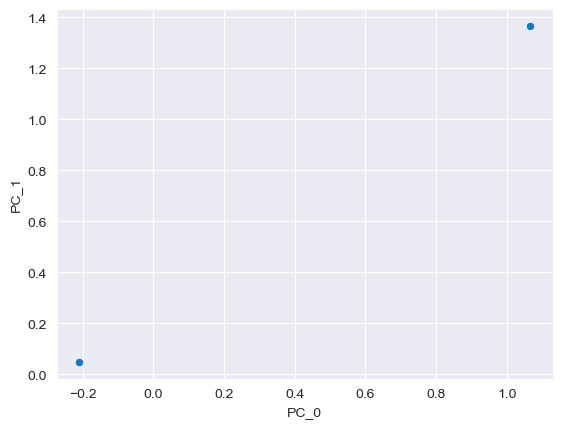

In [63]:
sns.scatterplot(
            x = 'PC_0', 
            y='PC_1',
            # hue=pca_df_sample['Before_or_after_controversy']
            data = pca_df_sample
            )

In [24]:


# fig = 
px.scatter(pca_df_sample.sample(n=100, random_state=12345), 
            'PC_0', 'PC_1', hover_name='display_name',  
            # animation_frame="Before_or_after_controversy", 
            # animation_group="display_name",
            hover_data={
                'PC_0':False,
                'PC_1':False, 
                'clean_tweet_text': True,
                'ElonMusk':False,
            }, color='Before_or_after_controversy',
            )
            

# fig["layout"].pop("updatemenus") # optional, drop animation buttons
# fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

<a id=one ><a/> 

## 4. Clustering
    
[LINK to table of contents](#contents)

To be able to cluster our tweets, we need to convert them to vector form first. To do that, we will be using word vectors from huggingface:
1. Load up huggingface pre-trained word vectors
2. Load up a pretrained sentiment analysis model
3. 

In [1]:
from transformers import BertTokenizer, TFBertForSequenceClassification, BertPreTrainedModel
from transformers import InputExample, InputFeatures
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
import pandas as pd
from scipy.special import softmax
import csv
import urllib.request

: 

: 

In [17]:

#pre-trained tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")


In [22]:
from transformers import pipeline


In [23]:
task = 'sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

tokenizer = AutoTokenizer.from_pretrained(MODEL)

# download label mapping
labels=[]
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]

# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.save_pretrained(MODEL)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)
Downloading: 100%|██████████| 629/629 [00:00<00:00, 231kB/s]
Downloading: 100%|██████████| 255M/255M [00:13<00:00, 19.6MB/s] 


: 

: 

In [18]:

#pretrained classifier
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")


TypeError: 'NoneType' object is not callable

Help on class TFBertForSequenceClassification in module transformers.utils.dummy_tf_objects:

class TFBertForSequenceClassification(builtins.object)
 |  TFBertForSequenceClassification(*args, **kwargs)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, *args, **kwargs)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



In [14]:
import tensorflow as tf
tf.version.VERSION

2022-10-11 09:02:12.756707: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


'2.10.0'

In [11]:
!pip install tensorflow

In [7]:
# let's subselect for tweets directed at ElonMusk:
at_elon = df.loc[df.extracted_twitter_handles.apply(lambda x : 'elonmusk' in x if x==x else False)]
at_elon.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25396 entries, 157 to 516558
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   tweet_id                   25396 non-null  float64
 1   datetime                   25396 non-null  object 
 2   display_name               25396 non-null  object 
 3   tweet_text                 25396 non-null  object 
 4   User_id                    25355 non-null  object 
 5   extracted_twitter_handles  25396 non-null  object 
 6   extracted_URLs             25396 non-null  object 
 7   extracted_hashtags         25396 non-null  object 
 8   clean_tweet_text           23993 non-null  object 
dtypes: float64(1), object(8)
memory usage: 1.9+ MB


In [8]:
at_elon.tail()

,tweet_id,datetime,display_name,tweet_text,User_id,extracted_twitter_handles,extracted_URLs,extracted_hashtags,clean_tweet_text
516535,1.578353e+18,2022-10-07 11:52:36+00:00,86kristi,"Be like Stephen King , not like @elonmusk 🥱\n#...",342630992.0,['@elonmusk'],['https://t.co/AYVZeyx0Ec'],['#StandWithUkraine'],Be like Stephen King not like 🥱 ✊🏻🇺🇦
516536,1.578340e+18,2022-10-07 11:03:49+00:00,86kristi,@Podolyak_M @NobelPrize Feels like kinda bond ...,342630992.0,"['@Podolyak_M', '@NobelPrize', '@elonmusk']",[],[],Feels like kinda bond between them and 🪢
516548,1.576997e+18,2022-10-03 18:05:41+00:00,86kristi,@elonmusk Everything was decided in 1991!!!,342630992.0,['@elonmusk'],[],[],Everything was decided in 1991
516549,1.576993e+18,2022-10-03 17:51:59+00:00,86kristi,"@elonmusk Dear Elon, you just dropped down tha...",342630992.0,['@elonmusk'],[],[],Dear Elon you just dropped down than Putin its...
516558,1.573978e+18,2022-09-25 10:08:10+00:00,86kristi,Dear @elonmusk brave Ukrainian friends &amp; s...,342630992.0,['@elonmusk'],['https://t.co/ZuwvrrbuhQ'],"['#Starlink', '#StandWithUkraine', '#Starlink'...",Dear brave Ukrainian friends amp soldiers are...


In [ ]:
tf_batch = tokenizer(pred_sentences, max_length=128, padding=True, truncation=True, return_tensors='tf')
tf_outputs = model(tf_batch)
tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
labels = ['Negative','Positive']
label = tf.argmax(tf_predictions, axis=1)
label = label.numpy()
for i in range(len(pred_sentences)):
  print(pred_sentences[i], ": \n", labels[label[i]])


<a id=two ><a/> 

## 5. EDA 2
    
[LINK to table of contents](#contents)

<a id=three ><a/> 

## 6. EDA 3
    
[LINK to table of contents](#contents)

<a id=conc ><a/> 

## 7. Conclusions and ideas going forward
    
[LINK to table of contents](#contents)